In [1]:
import torch
import torchvision
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
device

device(type='cpu')

In [3]:
# windows操作系统
plt.rcParams['font.sans-serif']=['SimHei']  # 用来正常显示中文标签 
plt.rcParams['axes.unicode_minus']=False  # 用来正常显示负号

In [4]:
from PIL import Image, ImageFont, ImageDraw
# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 32)

In [5]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [6]:
idx_to_labels

{0: 'Lv1', 1: 'Lv2', 2: 'lv3', 3: 'lv4', 4: 'lv5'}

In [7]:
model = torch.load('checkpoint/best-0.804.pth')
model = model.eval().to(device)

In [8]:
from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

## 载入一张测试图像

In [9]:
from PIL import Image

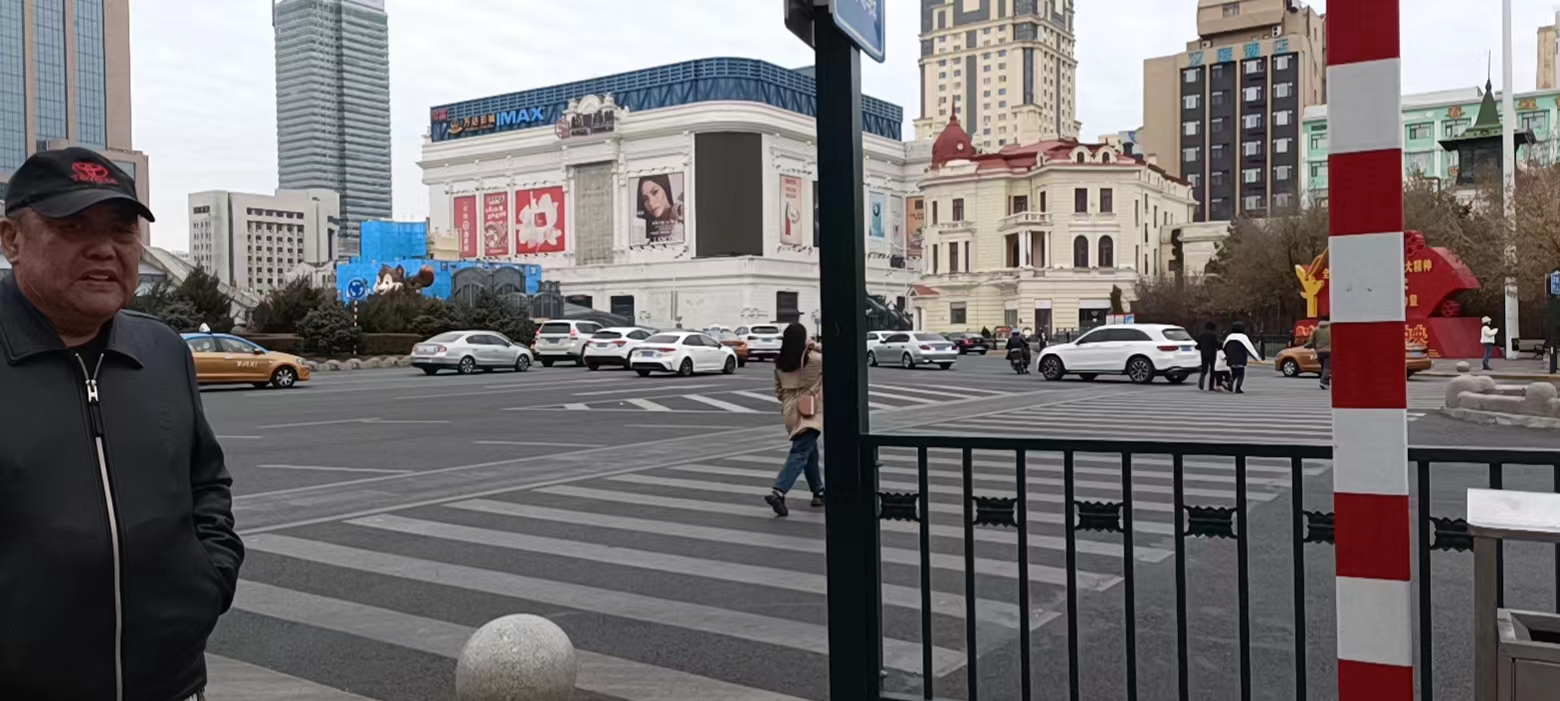

In [10]:
img_path = 'test_img/红军街/微信图片_20231105155930.jpg'
img_pil = Image.open(img_path)
img_pil

In [11]:
input_img = test_transform(img_pil) # 预处理

In [12]:
input_img.shape

torch.Size([3, 224, 224])

In [13]:
input_img = input_img.unsqueeze(0).to(device)

In [14]:
# 执行前向预测，得到所有类别的 logit 预测分数
pred_logits = model(input_img) 
pred_logits

tensor([[ 0.3054, -2.4875,  1.8084, -1.0875,  0.3907]],
       grad_fn=<AddmmBackward0>)

In [15]:
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
pred_softmax

tensor([[0.1451, 0.0089, 0.6521, 0.0360, 0.1580]], grad_fn=<SoftmaxBackward0>)

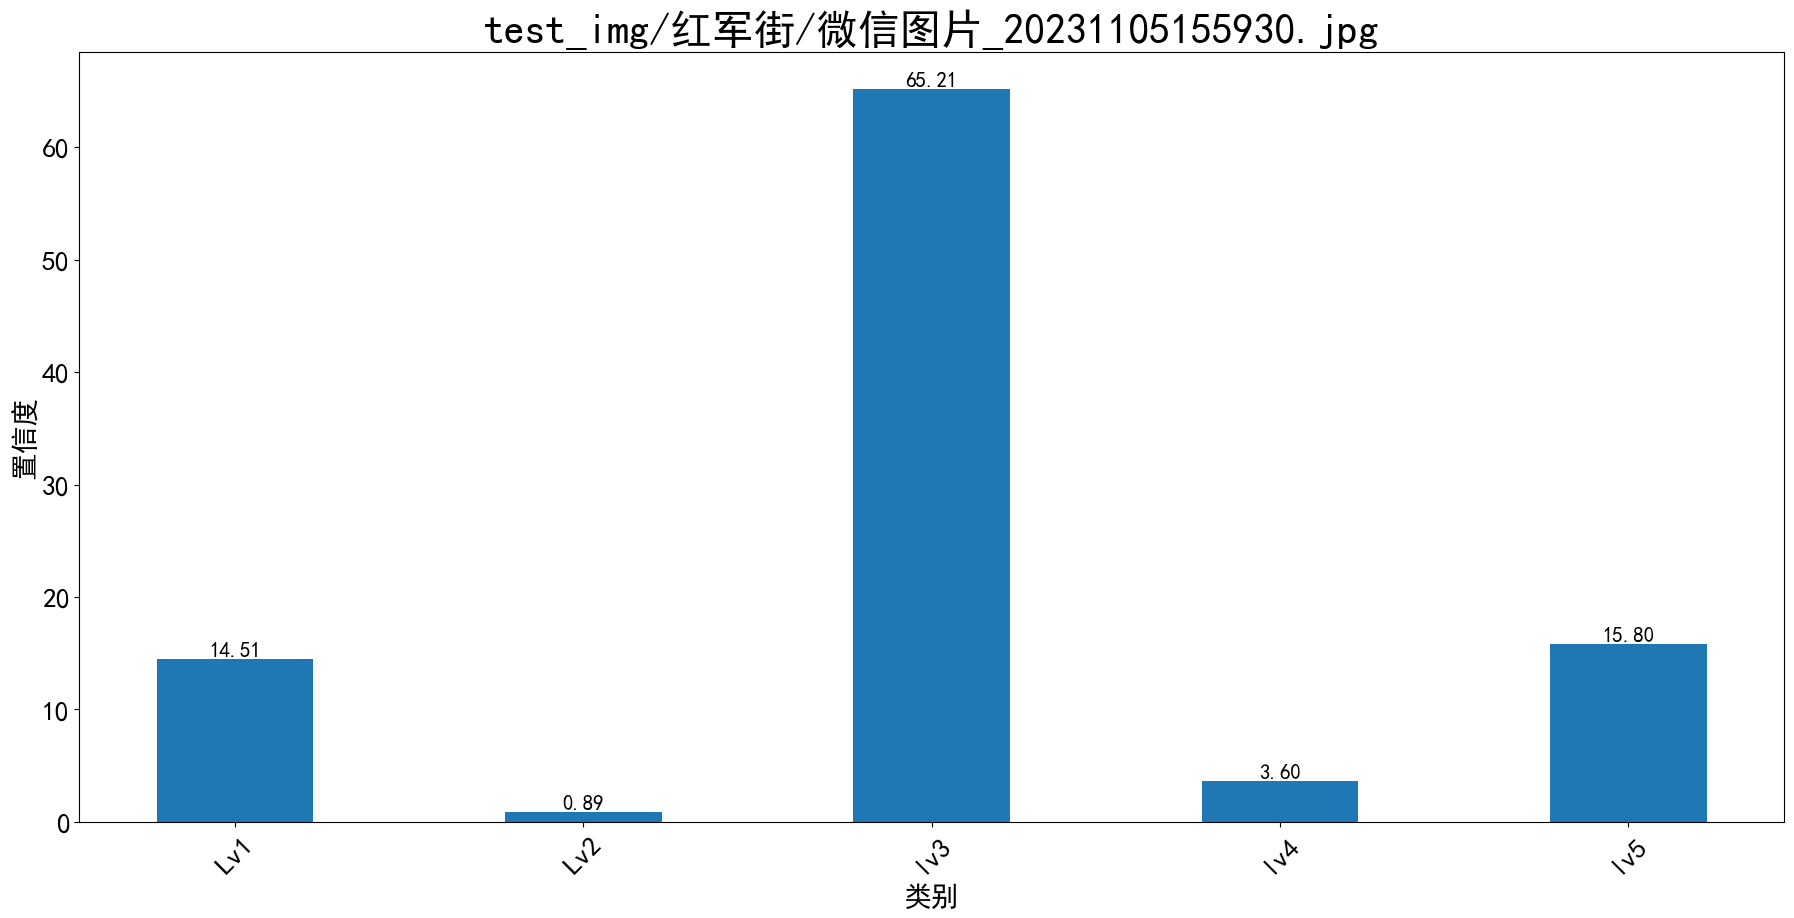

In [16]:
plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.show()

In [19]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        # root是图片所在的根目录
        self.root = root
        # transform是数据预处理的方法，可以是torchvision.transforms中的任意变换
        self.transform = transform
        # 获取所有图片的文件名，假设图片都是jpg格式
        self.images = os.listdir(root)

    def __len__(self):
        # 返回数据集的大小，即图片的数量
        return len(self.images)

    def __getitem__(self, index):
        # 获取图片的文件名
        image_name = self.images[index]
        # 读取图片，转换为RGB模式
        image = Image.open(os.path.join(self.root, image_name)).convert('RGB')
        # 如果有预处理方法，就对图片进行预处理
        if self.transform is not None:
            image = self.transform(image)
        # 返回图片张量和图片文件名，作为一个元组
        return image, image_name

In [30]:
from torch.utils.data import DataLoader
test_path = 'test_img/邮政街'

test_dataset = ImageDataset(test_path,test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 创建一个空的 DataFrame 用于保存结果
result_df = pd.DataFrame(columns=['image', 'label'])

# 遍历测试数据
for images, image_names in test_loader:
    # 将数据移动到设备上
    images = images.to(device)
    # 进行推理
    outputs = model(images)
    # 获取预测的标签
    preds = torch.argmax(outputs, dim=1)
    # 将图片的文件名和预测的标签添加到结果 DataFrame 中
    for image, pred, image_name in zip(images, preds, image_names):
        # # 获取图片的文件名
        # image_name = image.name
        # 获取预测的标签
        pred_label = pred.item()
        # 将文件名和标签添加到结果 DataFrame 中
        result_df = pd.concat([result_df, pd.DataFrame({'image': image_name, 'label': pred_label}, index=[0])], ignore_index=True)

# 保存结果到 csv 文件
result_df.to_csv('output/邮政街.csv', index=False)